In [1]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn tensorflow keras opencv-python imutils pillow # Install all the dependencies

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import string
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.applications import resnet, ResNet50,VGG16,ResNet101, VGG19
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
import random
import shutil
import imutils
from PIL import Image

# Training, Validation, and Test Sub-directory setup

In [3]:
# base directory
src_dir = './data/'

# subdirectories
train_dir = os.path.join(src_dir, 'Training')
test_dir = os.path.join(src_dir, 'Testing')

# Data Exploration & Preparation

ref: [finding-extreme-contours](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

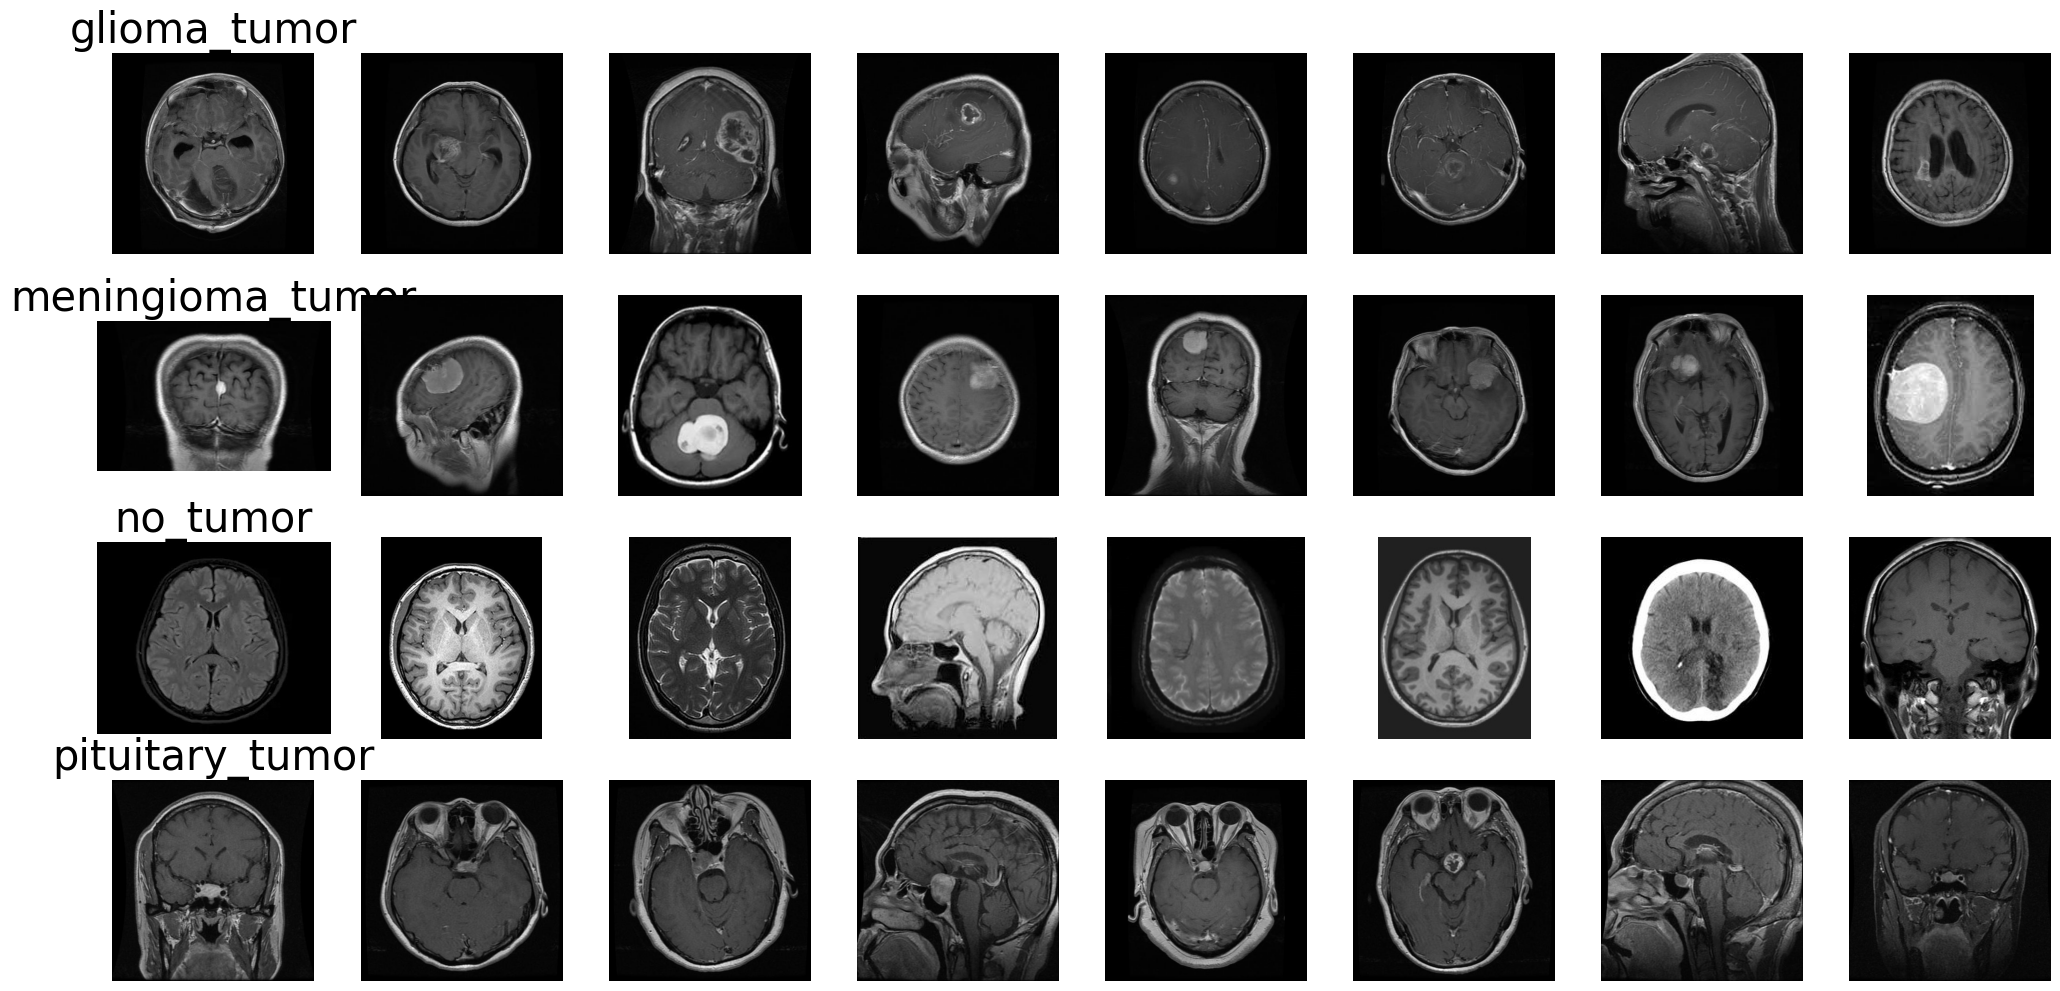

In [4]:
# Get a list of all subdirectories paths (each one is a class label)
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Specify the number of columns for your plot
ncols = 8

# Set up matplotlib fig
fig, ax = plt.subplots(len(categories), ncols, figsize=(20, 10))

# For each subdirectory, select random images
for i, subdir in enumerate(categories):
    subdir_path = os.path.join(train_dir, subdir) # Get full subdir path
    subdir_images = os.listdir(subdir_path) # Get list of dir contents
    random_image_names = random.sample(subdir_images, ncols) # Get a sample of dir content
    img_paths = [os.path.join(subdir_path, img_name) for img_name in random_image_names] # Append path to each sample image
    
    for j, img_path in enumerate(img_paths):
        # Set up subplot; subplot indices start at 1
        sp = ax[i, j]
        if j == 0:
            sp.set_title(os.path.basename(subdir), fontsize=30)  # set title to the first image of each row
        sp.axis('Off') # Don't show axes (or gridlines)

        img = mpimg.imread(img_path)
        sp.imshow(img) # Show random image

plt.tight_layout()
plt.show()

In [5]:
def visualize_transformations(img, debug_mode=False):
    """
    Applies transformations to the image and plots each step
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur
    gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply threshold
    thresh = cv2.threshold(gray_blurred, 45, 255, cv2.THRESH_BINARY)[1]

    # Apply erosion and dilation
    thresh_eroded = cv2.erode(thresh, None, iterations=2)
    thresh_dilated = cv2.dilate(thresh_eroded, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh_dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Find the largest contour
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the image
    PIXEL_PADDING = 0  # Adjust this value to your needs
    new_img = img[extTop[1]-PIXEL_PADDING:extBot[1]+PIXEL_PADDING, extLeft[0]-PIXEL_PADDING:extRight[0]+PIXEL_PADDING].copy()

    # If debug mode is enabled, plot the images
    if debug_mode:
        cnt_img = img.copy()

        # draw the outline of the object, then draw each of the
        # extreme points, where the left-most is red, right-most
        # is green, top-most is blue, and bottom-most is teal
        cv2.drawContours(cnt_img, [c], -1, (0, 255, 255), 2)
        cv2.circle(cnt_img, extLeft, 8, (0, 0, 255), -1)
        cv2.circle(cnt_img, extRight, 8, (0, 255, 0), -1)
        cv2.circle(cnt_img, extTop, 8, (255, 0, 0), -1)
        cv2.circle(cnt_img, extBot, 8, (255, 255, 0), -1)

        # Plot images
        fig, axs = plt.subplots(1, 7, figsize=(20, 20))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original Image')
        axs[1].imshow(gray, cmap='gray')
        axs[1].set_title('Grayscale Image')
        axs[2].imshow(gray_blurred, cmap='gray')
        axs[2].set_title('Blurred Image')
        axs[3].imshow(thresh, cmap='gray')
        axs[3].set_title('Thresholded Image')
        axs[4].imshow(thresh_dilated, cmap='gray')
        axs[4].set_title('Dilated Image')
        axs[5].imshow(cv2.cvtColor(cnt_img, cv2.COLOR_BGR2RGB))
        axs[5].set_title('Contour Image')
        axs[6].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
        axs[6].set_title('Cropped Image')

        for ax in axs:
            ax.axis('off')

    # If debug mode is not enabled, return the cropped image
    else:
        return new_img


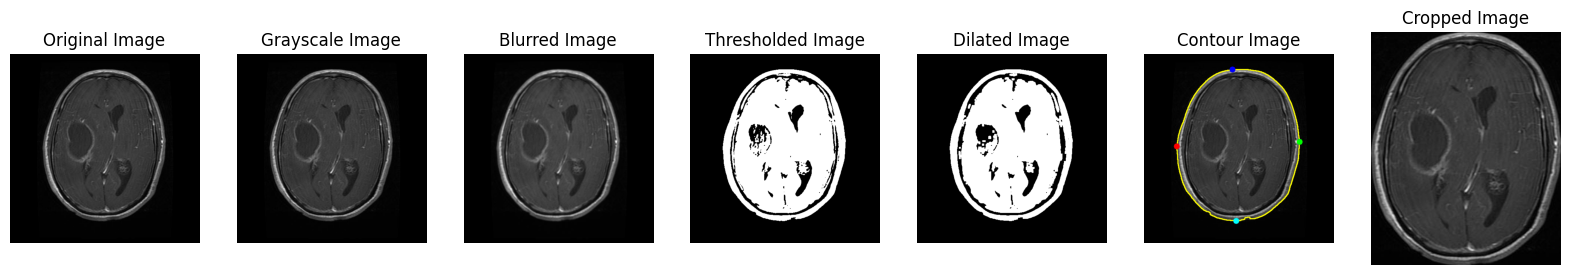

In [6]:
# Get the first image name from 'yes' directory
first_image_name = random.choice(os.listdir(os.path.join(src_dir, 'Training', 'glioma_tumor')))

# Get full path of the image
first_image_path = os.path.join(src_dir, 'Training', 'glioma_tumor', first_image_name)

# Now read the image
img = cv2.imread(first_image_path)

# Visualize the transformations
visualize_transformations(img, debug_mode=True)

In [7]:
def process_images(source_dir, target_dir):
    """
    Apply transformations to all images in the specified directory.
    The transformed images are saved in a new directory.
    """
    # Get all file names in the source directory
    for subfolder in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
        source_folder_path = os.path.join(source_dir, subfolder)
        filenames = os.listdir(source_folder_path)

        # Make the corresponding subfolder in the target directory
        target_folder_path = os.path.join(target_dir, subfolder)
        os.makedirs(target_folder_path, exist_ok=True)

        for filename in filenames:
            # Full path to the source file
            source_file_path = os.path.join(source_folder_path, filename)

            # Read the image
            img = cv2.imread(source_file_path)

            # If the image was successfully read
            if img is not None:
                # Apply the transformations (without visualizing)
                transformed_img = visualize_transformations(img, debug_mode=False)

                # OpenCV uses BGR color format, so we need to convert back from RGB
                transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR)

                # Full path to the target file
                target_file_path = os.path.join(target_folder_path, filename)

                # Write the transformed image to the target directory
                cv2.imwrite(target_file_path, transformed_img)
            else:
                print(f"Image {filename} could not be read")

# Paths to the source directories
train_dir = os.path.join(src_dir, 'Training')
valid_dir = os.path.join(src_dir, 'Testing')

# Paths to the target directories
cropped_train_dir = os.path.join(src_dir, 'data_cropped', 'Training')
cropped_valid_dir = os.path.join(src_dir, 'data_cropped', 'Testing')

# Apply the function to each directory
process_images(train_dir, cropped_train_dir)
process_images(valid_dir, cropped_valid_dir)


In [8]:
# Get the first image name from 'yes' directory
first_image_name = random.choice(os.listdir(os.path.join(src_dir, 'data_cropped', 'Training', 'glioma_tumor')))

# Get full path of the image
first_image_path = os.path.join(src_dir, 'data_cropped', 'Training', 'glioma_tumor', first_image_name)

# Now read the image
img = cv2.imread(first_image_path)

# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

_preview_dir = './data/preview'

if os.path.exists(_preview_dir):
    print("Removing existing directory: 'preview'")
    shutil.rmtree(_preview_dir)
os.mkdir(_preview_dir)

# load single image for example
x = img.reshape((1,) + img.shape) 

# create directory for augmented images
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir=_preview_dir, save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

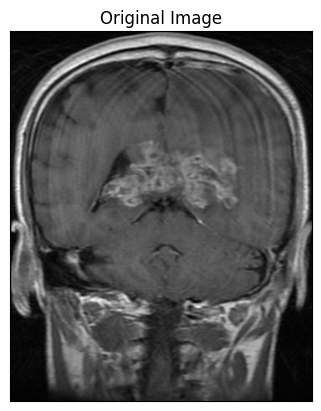

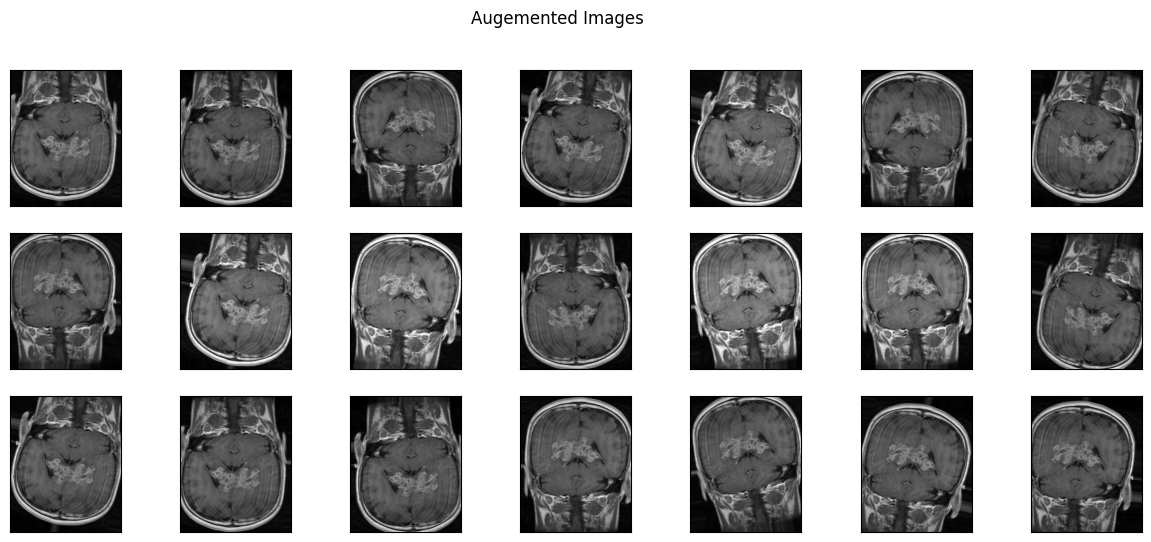

In [9]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir(_preview_dir):
    img = cv2.imread(os.path.join(_preview_dir, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

# Data Generator

In [10]:
def move_files(source_dir, target_dir, file_limit=100):
    # For each subfolder in the source directory
    for subfolder in os.listdir(source_dir):
        source_subfolder = os.path.join(source_dir, subfolder)
        target_subfolder = os.path.join(target_dir, subfolder)

        # Create the corresponding subfolder in the target directory if it doesn't exist
        os.makedirs(target_subfolder, exist_ok=True)

        # Get a list of file names in the subfolder
        filenames = os.listdir(source_subfolder)

        # Choose a random sample of files
        chosen_files = random.sample(filenames, file_limit)

        # For each chosen file
        for filename in chosen_files:
            # Move the file to the target subfolder
            shutil.move(os.path.join(source_subfolder, filename), os.path.join(target_subfolder, filename))

In [11]:
test_dir = './data/data_cropped/Test'
if os.path.exists(test_dir):
    print("Removing existing directory: 'Test'")
    shutil.rmtree(test_dir)
os.mkdir(os.path.join(src_dir, 'data_cropped', 'Test'))

# Paths to the source (training) and target (testing) directories
train_dir = './data/data_cropped/Training'
test_dir = './data/data_cropped/Test'

# Move a random sample of 100 files from each subfolder of the training directory to the testing directory
move_files(train_dir, test_dir, file_limit=25)


In [12]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

TRAIN_DIR = './data/data_cropped/Training'
VAL_DIR = './data/data_cropped/Testing'
TEST_DIR = './data/data_cropped/Test'
IMG_SIZE = (256, 256)
CLASS_MODE = 'categorical'

train_datagen = ImageDataGenerator(
    # rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    # vertical_flip=True,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode=CLASS_MODE,
    shuffle=False,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode=CLASS_MODE,
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=20,
        class_mode=CLASS_MODE,
        shuffle=False)

Found 2770 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [13]:
from tensorflow.keras.applications import efficientnet

pre_trained_model = efficientnet.EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [14]:
# pre_trained_model = VGG16(input_shape = (256, 256, 3), 
#                           include_top = False, 
#                           classifier_activation='softmax',
#                           classes=4)

# # Freeze the weights of the layers.
# for layer in pre_trained_model.layers:
#     layer.trainable = False


In [15]:
EPOCHS = 30
myCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min',
    patience=6,
    restore_best_weights=True
)


reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [37]:
from tensorflow.keras.optimizers.legacy import Adam

model = tf.keras.Sequential([
    pre_trained_model,  # Pretrained base
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['acc'])

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 1280)        0         
                                                                 
 flatten_3 (Flatten)         (None, 81920)             0         
                                                                 
 dense_4 (Dense)             (None, 4)                 327684    
                                                                 
Total params: 4377255 (16.70 MB)
Trainable params: 327684 (1.25 MB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [39]:
history = model.fit(train_generator, epochs=100, validation_data=validation_generator, verbose=1, callbacks=[reduce_lr, myCallback])

Epoch 1/100
87/87 [==============================] - 39s 423ms/step - loss: 5.2057 - acc: 0.5845 - val_loss: 9.8069 - val_acc: 0.4619 - lr: 5.0000e-04
Epoch 2/100
87/87 [==============================] - 36s 415ms/step - loss: 2.6941 - acc: 0.7365 - val_loss: 2.8739 - val_acc: 0.6878 - lr: 5.0000e-04
Epoch 3/100
87/87 [==============================] - 36s 415ms/step - loss: 1.2957 - acc: 0.8245 - val_loss: 4.1132 - val_acc: 0.6320 - lr: 5.0000e-04
Epoch 4/100
87/87 [==============================] - 36s 414ms/step - loss: 2.9989 - acc: 0.7448 - val_loss: 2.6373 - val_acc: 0.7563 - lr: 5.0000e-04
Epoch 5/100
87/87 [==============================] - 36s 408ms/step - loss: 1.1098 - acc: 0.8747 - val_loss: 2.3232 - val_acc: 0.7716 - lr: 5.0000e-04
Epoch 6/100
87/87 [==============================] - 35s 403ms/step - loss: 0.5197 - acc: 0.9181 - val_loss: 2.7832 - val_acc: 0.7360 - lr: 5.0000e-04
Epoch 7/100
87/87 [==============================] - 35s 396ms/step - loss: 0.2894 - acc: 0.94

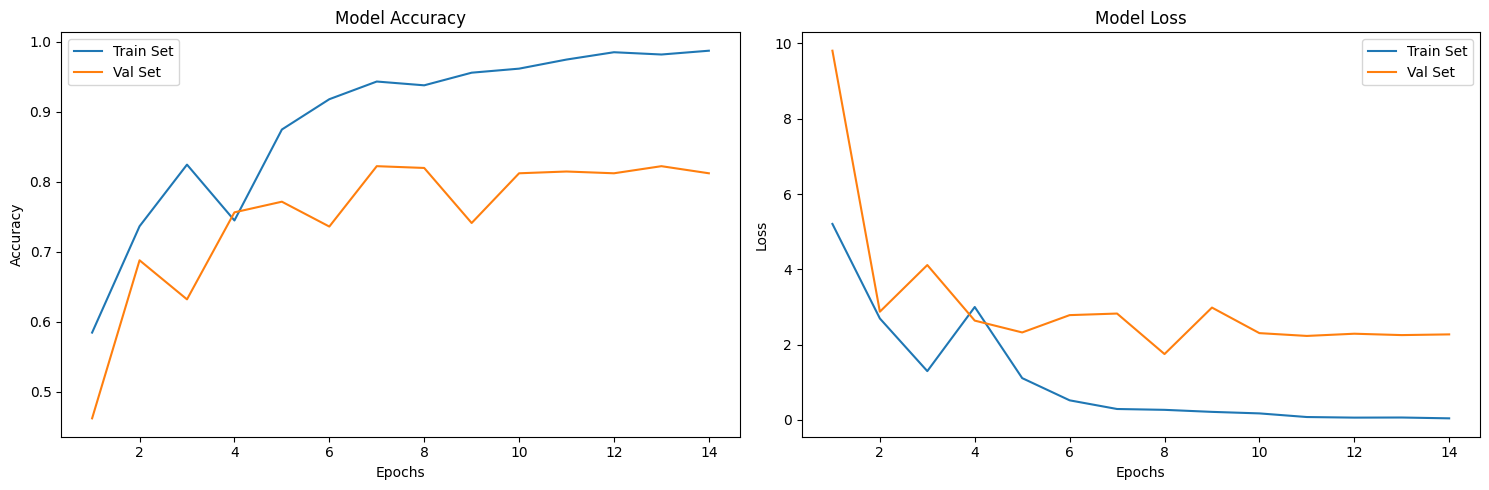

In [40]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Evaluations


## Eval (Val)

In [41]:
def metrics2dt(acc, rc, pr, f1):
    return pd.DataFrame(data={"Accuracy":acc, "Recall":rc, "Precision":pr, "F1-Score":f1}, index=[0])

def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    recall = recall.result().numpy()
    
    precision.update_state(y_true, y_pred)
    precision = precision.result().numpy()
    
    accuracy.update_state(y_true, y_pred)
    accuracy = accuracy.result().numpy()
    
    f1_score = 0
    if recall+precision != 0:
        f1_score = 2 * ((recall*precision)/(recall+precision))
    
    return metrics2dt(accuracy, recall, precision, f1_score)

25/25 [==============================] - 6s 189ms/step


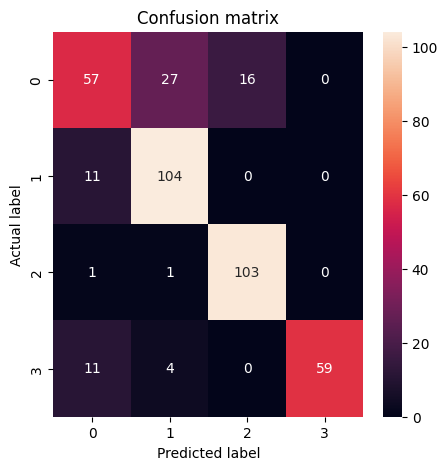

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming that you have the true labels
true_labels = validation_generator.classes

# Get the predicted probabilities from the model
predicted_probs = history.model.predict(validation_generator, steps=len(validation_generator))

# Convert probabilities to class labels: if you're working on a binary classification problem
# predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probs]

# If you're working on a multi-class classification problem, use argmax
predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot it using seaborn
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [43]:
show_metrics(true_labels, predicted_labels)

,Accuracy,Recall,Precision,F1-Score
0,0.819797,0.921769,0.863057,0.891447


## Eval (Test)

In [44]:
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))

5/5 [==============================] - 1s 216ms/step - loss: 0.8197 - acc: 0.9000


5/5 [==============================] - 1s 224ms/step


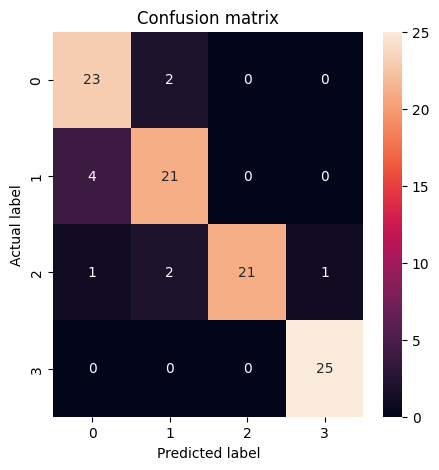

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming that you have the true labels
true_labels = test_generator.classes

# Get the predicted probabilities from the model
predicted_probs = history.model.predict(test_generator, steps=len(test_generator))

# Convert probabilities to class labels: if you're working on a binary classification problem
# predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probs]

# If you're working on a multi-class classification problem, use argmax
predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot it using seaborn
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [46]:
show_metrics(true_labels, predicted_labels)

,Accuracy,Recall,Precision,F1-Score
0,0.9,0.933333,0.972222,0.952381


In [48]:
model.save('./output_model/brain_tumor.keras')